# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [56]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [57]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
# os.environ["HOPSWORKS_API_KEY"] = ""

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1167510
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [58]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality_lagging_feature',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather_lagging_feature',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [59]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm25', 'pm25_lagging_3day_mean']).join(weather_fg.select_all(), on=['city'])
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.58s) 


,pm25,pm25_lagging_3day_mean,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,13.0,10.000000,2017-10-07 00:00:00+00:00,6.131084,6.300001,14.332341,343.018829,stockholm
1,8.0,10.000000,2017-10-08 00:00:00+00:00,6.637333,23.200001,28.442278,343.866455,stockholm
2,7.0,9.666667,2017-10-09 00:00:00+00:00,8.237334,14.600002,23.377836,3.614363,stockholm
3,12.0,9.333333,2017-10-10 00:00:00+00:00,6.964418,0.300000,22.771244,309.045013,stockholm
4,12.0,9.000000,2017-10-11 00:00:00+00:00,6.922750,1.400000,13.684735,273.607208,stockholm
5,10.0,10.333333,2017-10-12 00:00:00+00:00,10.216500,13.299999,20.192118,211.184906,stockholm
6,9.0,11.333333,2017-10-13 00:00:00+00:00,8.006085,2.500000,28.856194,326.976105,stockholm
7,11.0,10.333333,2017-10-14 00:00:00+00:00,11.681083,2.300000,20.833395,249.373688,stockholm
8,21.0,10.000000,2017-10-15 00:00:00+00:00,10.972751,0.000000,18.626305,252.897125,stockholm
9,28.0,13.666667,2017-10-16 00:00:00+00:00,13.135250,0.000000,27.397867,260.601074,stockholm


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [60]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv_lagging_feature',
    description="weather features with air quality as the target for stockholm hornsgatan-108 (for lagging feature)",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [61]:
start_date_test_data = "2024-10-15"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [62]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.40s) 


In [63]:
X_train

,pm25_lagging_3day_mean,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,10.000000,2017-10-07 00:00:00+00:00,6.131084,6.300001,14.332341,343.018829,stockholm
1,10.000000,2017-10-08 00:00:00+00:00,6.637333,23.200001,28.442278,343.866455,stockholm
2,9.666667,2017-10-09 00:00:00+00:00,8.237334,14.600002,23.377836,3.614363,stockholm
3,9.333333,2017-10-10 00:00:00+00:00,6.964418,0.300000,22.771244,309.045013,stockholm
4,9.000000,2017-10-11 00:00:00+00:00,6.922750,1.400000,13.684735,273.607208,stockholm
...,...,...,...,...,...,...,...
2480,23.333333,2024-10-10 00:00:00+00:00,12.429000,18.600000,23.946089,170.058411,stockholm
2481,22.000000,2024-10-11 00:00:00+00:00,7.841501,2.100000,18.913708,255.033203,stockholm
2482,15.000000,2024-10-12 00:00:00+00:00,8.145667,0.100000,18.466455,221.849167,stockholm
2483,12.333333,2024-10-13 00:00:00+00:00,9.670666,1.400000,18.710478,127.486992,stockholm


In [64]:
X_test

,pm25_lagging_3day_mean,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
2485,14.000000,2024-10-15 00:00:00+00:00,4.847750,0.0,13.776762,299.739532,stockholm
2486,13.666667,2024-10-16 00:00:00+00:00,6.399834,0.0,13.036026,217.705414,stockholm
2487,14.333333,2024-10-17 00:00:00+00:00,10.295669,0.0,21.060768,185.962173,stockholm
2488,13.000000,2024-10-18 00:00:00+00:00,10.864417,0.0,16.801823,183.901047,stockholm
2489,21.333333,2024-10-19 00:00:00+00:00,11.162333,0.0,19.453329,172.556854,stockholm
2490,27.333333,2024-10-20 00:00:00+00:00,12.179000,0.1,22.725668,182.932281,stockholm
2491,39.000000,2024-10-21 00:00:00+00:00,13.168583,0.0,24.738707,219.984772,stockholm
2492,41.000000,2024-10-22 00:00:00+00:00,10.522750,0.0,24.193098,240.084961,stockholm
2493,38.000000,2024-10-23 00:00:00+00:00,10.116500,0.0,25.471750,261.736389,stockholm
2494,27.000000,2024-10-24 00:00:00+00:00,11.003999,0.0,20.880001,261.377655,stockholm


In [65]:
# Drop the index columns - 'date' (event_time) and 'city' (primary key)

train_features = X_train.drop(['date', 'city'], axis=1)
test_features = X_test.drop(['date', 'city'], axis=1)

In [66]:
y_train

,pm25
0,13.0
1,8.0
2,7.0
3,12.0
4,12.0
...,...
2480,19.0
2481,7.0
2482,11.0
2483,14.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [67]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(train_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [68]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 91.15111
R squared: 0.207704557143086


In [69]:
df = y_test
df['predicted_pm25'] = y_pred
df.head(5)

,pm25,predicted_pm25
2485,10.0,21.460184
2486,16.0,17.473574
2487,13.0,24.425722
2488,35.0,21.031752
2489,34.0,34.500103


In [70]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])

In [71]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

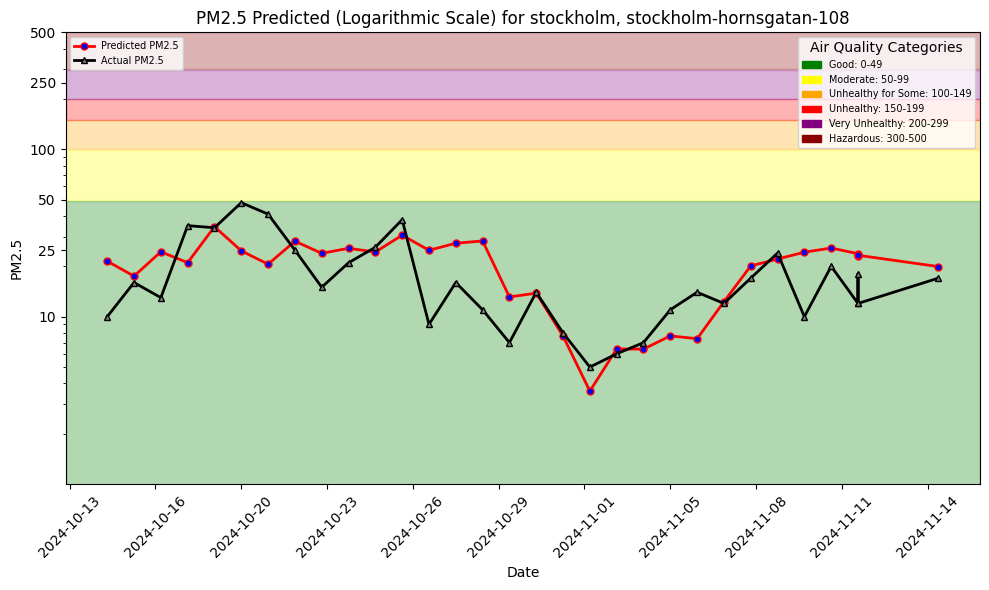

In [72]:
file_path = images_dir + "/pm25_hindcast_lagging_feature.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

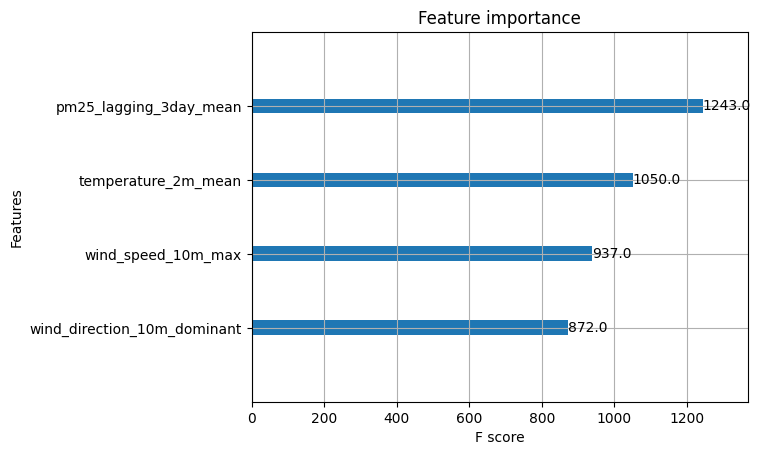

In [73]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=4)
feature_importance_path = images_dir + "/feature_importance_lagging_feature.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [74]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [75]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model-lagging-feature.json")

In [76]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [78]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_lagging_feature_xgboost_model", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Air Quality (PM2.5) predictor For Stockholm Hornsgatan-108, which uses Lagging Mean of Air Quality over 3 days",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/513826 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/6148 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/532329 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/20068 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19601 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/82350 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/78929 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/142 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/730 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1167510/models/air_quality_lagging_feature_xgboost_model/1


Model(name: 'air_quality_lagging_feature_xgboost_model', version: 1)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
